In [19]:
import requests
import pandas as pd
import numpy as np
import time

In [20]:
API_KEY="fa973a68b9f64242bcfbc94f5e5dd5d2"
BIRDEYE_URL = "https://public-api.birdeye.so/defi/history_price"

def get_price_history(mint, start, end, interval="15m"):
    url = (
        f"{BIRDEYE_URL}"
        f"?address={mint}"
        f"&address_type=token"
        f"&type={interval}"
        f"&time_from={start}"
        f"&time_to={end}"
        f"&ui_amount_mode=raw"
    )

    headers = {
        "accept": "application/json",
        "x-chain": "solana",
        "X-API-KEY": API_KEY
    }

    resp = requests.get(url, headers=headers).json()

    # Check if API failed
    if not resp.get("success"):
        raise Exception(f"Birdeye error: {resp.get('message')}")

    items = resp["data"].get("items", [])

    # If no data, return empty dataframe instead of crashing
    if not items:
        print(f"[WARN] No price history returned for {mint}")
        return pd.DataFrame(columns=["unixTime", "price"])

    df = pd.DataFrame(items)

    # Sometimes keys are 'unixTime', sometimes 'unix_time'
    if "unixTime" not in df.columns:
        if "unix_time" in df.columns:
            df.rename(columns={"unix_time": "unixTime"}, inplace=True)
        else:
            raise Exception(f"[ERROR] History for {mint} missing unixTime column. Columns: {df.columns}")

    if "value" not in df.columns:
        raise Exception(f"[ERROR] History for {mint} missing price 'value' column. Columns: {df.columns}")

    df.rename(columns={"value": "price"}, inplace=True)
    return df[["unixTime", "price"]]


In [48]:
mints = {
    "SOL": "So11111111111111111111111111111111111111112",
    "RAY": "4k3Dyjzvzp8eMZWUXbBCjEvwSkkk59S5iCNLY3QrkX6R",
    "ORCA": "orcaEKTdK7LKz57vaAYr9QeNsVEPfiu6QeMU1kektZE",
    "JTO": "jtojtomepa8beP8AuQc6eXt5FriJwfFMwQx2v2f9mCL",
    "MNDE": "MNDEFzGvMt87ueuHvVU9VcTqsAP5b3fTGPsHuuPA5ey",
    "BONK": "DezXAZ8z7PnrnRJjz3wXBoRgixCa6xjnB7YaB1pPB263"
}

alts = ["JTO", "MNDE"]

# --------------------------------------------
# 2. Fetch price history
# --------------------------------------------
now = int(time.time())
days = 30
start = now - days * 24 * 60 * 60
end = now

dfs = {}
for sym, mint in mints.items():
    dfs[sym] = get_price_history(mint, start, end, interval="5m")

# --------------------------------------------
# 3. Merge SOL with all alts using ONE loop
# --------------------------------------------
df = dfs["SOL"][["unixTime", "price"]].rename(columns={"price": "SOL"})

for sym in alts:          # <--- use alts here
    df = df.merge(
        dfs[sym][["unixTime", "price"]].rename(columns={"price": sym}),
        on="unixTime",
        how="inner"
    )

df.head()


,unixTime,SOL,JTO,MNDE
0,1761049800,186.632766,1.085575,0.107667
1,1761050100,187.237379,1.089902,0.107913
2,1761050400,187.599545,1.091587,0.108306
3,1761050700,186.870022,1.087758,0.108306
4,1761051000,187.032946,1.087282,0.108306


In [49]:
returns = df.drop(columns=["unixTime"]).apply(lambda x: np.log(x / x.shift(1)))
returns = returns.dropna()
returns.head()


,SOL,JTO,MNDE
1,0.003234,0.003977,0.002283
2,0.001932,0.001545,0.003637
3,-0.003896,-0.003514,0.000000
4,0.000871,-0.000438,0.000000
5,-0.002758,-0.003296,-0.004129


In [50]:
corr = returns.corr()
print(corr)


           SOL       JTO     MNDE
SOL   1.000000  0.532932  0.19858
JTO   0.532932  1.000000  0.13477
MNDE  0.198580  0.134770  1.00000


In [51]:
def compute_beta(y, x):
    return np.cov(y, x)[0][1] / np.var(x)

beta = {}
for sym in alts:
    beta[sym] = compute_beta(returns[sym], returns["SOL"])

basket_beta = sum(beta[sym] for sym in alts) / len(alts)
basket_ret = returns[alts].mean(axis=1)
residual = basket_ret - basket_beta * returns["SOL"]


In [52]:
residual.describe()
residual.mean()          # alpha
residual.std()           # volatility
(residual.mean() / residual.std()) * np.sqrt(252*24*12)  # annualized Sharpe, 5m bars


np.float64(1.0366674951152588)

Fetching SOL…
Fetching JTO…
Fetching MNDE…
Merged df: (1000, 4)


,unixTime,SOL,JTO,MNDE
0,1761050100,187.237379,1.089902,0.107913
1,1761050400,187.599545,1.091587,0.108306
2,1761050700,186.870022,1.087758,0.108306
3,1761051000,187.032946,1.087282,0.108306
4,1761051300,186.517731,1.083704,0.107860



Correlation matrix:


,SOL,JTO,MNDE
SOL,1.000000,0.532271,0.197656
JTO,0.532271,1.000000,0.133857
MNDE,0.197656,0.133857,1.000000



Betas: {'JTO': np.float64(0.8346104453989396), 'MNDE': np.float64(0.25816502715131767)}
Basket beta: 0.5463877362751286

Residual stats:
mean: 9.752762133347757e-06
std: 0.0022034566170515686
Sharpe: 1.1923936155862953


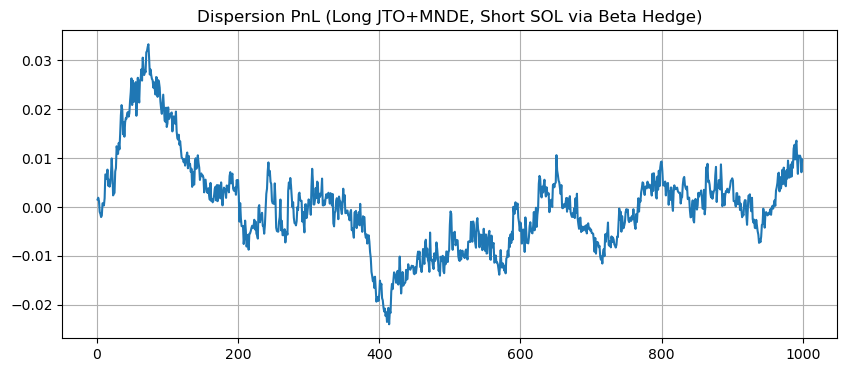

In [55]:
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================
# CONFIG
# ============================
INTERVAL = "5m"      # can be "1m", "5m", "15m", "1h"
DAYS = 30           # backtest period

mints = {
    "SOL":  "So11111111111111111111111111111111111111112",
    "JTO":  "jtojtomepa8beP8AuQc6eXt5FriJwfFMwQx2v2f9mCL",
    "MNDE": "MNDEFzGvMt87ueuHvVU9VcTqsAP5b3fTGPsHuuPA5ey"
}

alts = ["JTO", "MNDE"]   # dispersion basket


# ============================
# FETCH PRICE HISTORY
# ============================

def get_price_history(mint, start, end, interval=INTERVAL):
    url = (
        "https://public-api.birdeye.so/defi/history_price"
        f"?address={mint}"
        f"&address_type=token"
        f"&type={interval}"
        f"&time_from={start}"
        f"&time_to={end}"
        f"&ui_amount_mode=raw"
    )

    headers = {
        "accept": "application/json",
        "x-chain": "solana",
        "X-API-KEY": API_KEY
    }

    resp = requests.get(url, headers=headers).json()

    if not resp.get("success"):
        raise Exception(f"Birdeye error: {resp.get('message')}")

    items = resp["data"].get("items", [])
    if not items:
        raise Exception(f"No history returned for {mint}")

    df = pd.DataFrame(items)[["unixTime", "value"]]
    df = df.rename(columns={"value": "price"})
    return df


# ============================
# BUILD PANEL
# ============================

now = int(time.time())
start = now - DAYS * 24 * 60 * 60
end = now

dfs = {}
for sym, mint in mints.items():
    print(f"Fetching {sym}…")
    dfs[sym] = get_price_history(mint, start, end)

df = dfs["SOL"][["unixTime", "price"]].rename(columns={"price": "SOL"})
for sym in alts:
    df = df.merge(
        dfs[sym][["unixTime", "price"]].rename(columns={"price": sym}),
        on="unixTime",
        how="inner"
    )

print("Merged df:", df.shape)
display(df.head())


# ============================
# COMPUTE LOG RETURNS
# ============================

returns = df.drop(columns=["unixTime"]).apply(lambda x: np.log(x / x.shift(1)))
returns = returns.dropna()

print("\nCorrelation matrix:")
display(returns.corr())


# ============================
# COMPUTE BETAS
# ============================

def compute_beta(y, x):
    cov = np.cov(y, x)[0][1]
    var = np.var(x)
    return cov / var if var > 0 else 0.0

betas = {sym: compute_beta(returns[sym], returns["SOL"]) for sym in alts}
basket_beta = np.mean(list(betas.values()))

print("\nBetas:", betas)
print("Basket beta:", basket_beta)


# ============================
# BUILD HEDGED DISPERSION PNL
# ============================

basket_ret = returns[alts].mean(axis=1)
residual = basket_ret - basket_beta * returns["SOL"]

mu = residual.mean()
sigma = residual.std()
ann_factor = np.sqrt(252 * 24 * 12)   # annualize 5m bars

sharpe = (mu / sigma) * ann_factor if sigma > 0 else 0

print("\nResidual stats:")
print("mean:", mu)
print("std:", sigma)
print("Sharpe:", sharpe)

# ============================
# PLOT PNL
# ============================

plt.figure(figsize=(10,4))
plt.plot(residual.cumsum())
plt.title("Dispersion PnL (Long JTO+MNDE, Short SOL via Beta Hedge)")
plt.grid(True)
plt.show()


Fetching SOL…
Fetching JTO…
Fetching MNDE…
Merged df: (1000, 4)

Correlation matrix:


,SOL,JTO,MNDE
SOL,1.000000,0.529783,0.194708
JTO,0.529783,1.000000,0.128937
MNDE,0.194708,0.128937,1.000000



Betas: {'JTO': np.float64(0.832822467410463), 'MNDE': np.float64(0.2565313425885127)}
Basket beta: 0.5446769049994878

Residual stats:
mean: 1.3836401029091988e-05
std: 0.0018156193231089269
Sharpe: 2.0530279365124984


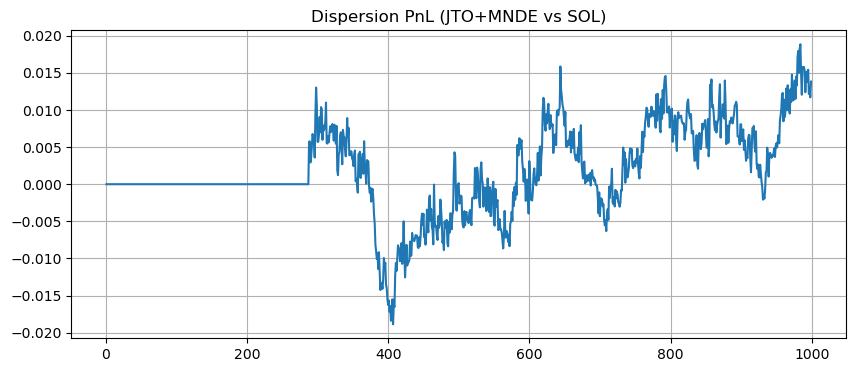


[REBALANCE] Building price panel for last 7 days…
Fetching SOL…
Fetching JTO…
Fetching MNDE…
Merged df: (1000, 4)
[REBALANCE] Betas: {'JTO': np.float64(0.8845350158266039), 'MNDE': np.float64(0.2861945743614054)}
[REBALANCE] Spot prices: {'SOL': 141.6872379731946, 'JTO': 0.5649680277481887, 'MNDE': 0.07287959905440491}
[REBALANCE] Target notionals (USD): {'JTO': 500.0, 'MNDE': 500.0, 'SOL_PERP': np.float64(-585.3647950940046)}
[REBALANCE] Target sizes: {'JTO': 885.0058329722943, 'MNDE': 6860.63049862209, 'SOL_PERP': np.float64(-4.131386873422913)}
[DRIFT] Target SOL-PERP size: -4.1314 SOL
[KAMINO] Rebalance JTO vault KAMINO_VAULT_ID_FOR_JTO_LP: target 885.0058 JTO
[KAMINO] Rebalance MNDE vault KAMINO_VAULT_ID_FOR_MNDE_LP: target 6860.6305 MNDE


In [60]:
import math
from typing import Dict, List

# Mints
MINTS = {
    "SOL":  "So11111111111111111111111111111111111111112",
    "JTO":  "jtojtomepa8beP8AuQc6eXt5FriJwfFMwQx2v2f9mCL",
    "MNDE": "MNDEFzGvMt87ueuHvVU9VcTqsAP5b3fTGPsHuuPA5ey"
}

ALTS = ["JTO", "MNDE"]

# Kamino vault IDs (you must fill the actual vault IDs)
KAMINO_VAULTS = {
    "JTO":  "KAMINO_VAULT_ID_FOR_JTO_LP",
    "MNDE": "KAMINO_VAULT_ID_FOR_MNDE_LP"
}

# Drift SOL-perp market identifier (check Drift docs / SDK)
DRIFT_SOL_PERP_MARKET = "SOL-PERP"   # placeholder

INTERVAL = "5m"
BACKTEST_DAYS = 30
REBALANCE_HOURS = 4
RISK_FREE_RATE = 0.0

# Capital and allocation
TOTAL_CAPITAL_USD = 2000.0
ALT_FRACTION = 0.50  # 50% into JTO+MNDE

# Regime filter thresholds
MAX_CORR_SOL_JTO = 0.75
MAX_CORR_SOL_MNDE = 0.50


# =========================================
# BIRDEYE DATA HELPERS
# =========================================

def get_price_history(mint: str, start: int, end: int, interval: str = INTERVAL) -> pd.DataFrame:
    url = (
        "https://public-api.birdeye.so/defi/history_price"
        f"?address={mint}"
        f"&address_type=token"
        f"&type={interval}"
        f"&time_from={start}"
        f"&time_to={end}"
        f"&ui_amount_mode=raw"
    )
    headers = {
        "accept": "application/json",
        "x-chain": "solana",
        "X-API-KEY": API_KEY
    }
    resp = requests.get(url, headers=headers).json()
    if not resp.get("success"):
        raise Exception(f"Birdeye error for {mint}: {resp.get('message')}")
    items = resp["data"].get("items", [])
    if not items:
        raise Exception(f"No history returned for {mint}")
    df = pd.DataFrame(items)[["unixTime", "value"]]
    df = df.rename(columns={"value": "price"})
    return df


def build_price_panel(days: int = BACKTEST_DAYS, interval: str = INTERVAL) -> pd.DataFrame:
    now = int(time.time())
    start = now - days * 24 * 60 * 60
    end = now

    dfs = {}
    for sym, mint in MINTS.items():
        print(f"Fetching {sym}…")
        dfs[sym] = get_price_history(mint, start, end, interval)

    df = dfs["SOL"][["unixTime", "price"]].rename(columns={"price": "SOL"})
    for sym in ALTS:
        df = df.merge(
            dfs[sym][["unixTime", "price"]].rename(columns={"price": sym}),
            on="unixTime",
            how="inner"
        )

    df = df.sort_values("unixTime").reset_index(drop=True)
    print("Merged df:", df.shape)
    return df


def get_spot_prices() -> Dict[str, float]:
    """
    Fetch live spot prices for SOL, JTO, MNDE using the universal Birdeye price endpoint:
    https://public-api.birdeye.so/defi/price?address=<mint>
    """
    out = {}
    for sym, mint in MINTS.items():
        url = f"https://public-api.birdeye.so/defi/price?address={mint}"
        headers = {
            "accept": "application/json",
            "x-chain": "solana",
            "X-API-KEY": API_KEY
        }
        resp = requests.get(url, headers=headers).json()
        if not resp.get("success"):
            raise Exception(f"Birdeye price error for {sym}: {resp.get('message')}")
        out[sym] = resp["data"]["value"]
    return out




# =========================================
# STATS & BACKTEST
# =========================================

def compute_log_returns(price_df: pd.DataFrame) -> pd.DataFrame:
    returns = price_df.drop(columns=["unixTime"]).apply(lambda x: np.log(x / x.shift(1)))
    return returns.dropna()


def compute_beta(y: pd.Series, x: pd.Series) -> float:
    cov = np.cov(y, x)[0][1]
    var = np.var(x)
    return cov / var if var > 0 else 0.0


def run_backtest(price_df: pd.DataFrame, regime_filter: bool = True):
    returns = compute_log_returns(price_df)

    print("\nCorrelation matrix:")
    display(returns.corr())

    # betas vs SOL
    betas = {sym: compute_beta(returns[sym], returns["SOL"]) for sym in ALTS}
    basket_beta = np.mean(list(betas.values()))
    print("\nBetas:", betas)
    print("Basket beta:", basket_beta)

    basket_ret = returns[ALTS].mean(axis=1)
    residual = basket_ret - basket_beta * returns["SOL"]

    if regime_filter:
        roll = 288  # ~ 1 day of 5m bars
        roll_corr_jto = returns["SOL"].rolling(roll).corr(returns["JTO"])
        roll_corr_mnde = returns["SOL"].rolling(roll).corr(returns["MNDE"])
        mask = (roll_corr_jto <= MAX_CORR_SOL_JTO) & (roll_corr_mnde <= MAX_CORR_SOL_MNDE)
        residual_filtered = residual.copy()
        residual_filtered[~mask] = 0.0
        residual = residual_filtered

    mu = residual.mean()
    sigma = residual.std()
    ann_factor = math.sqrt(252 * 24 * 12)
    sharpe = (mu - RISK_FREE_RATE) / sigma * ann_factor if sigma > 0 else 0.0

    print("\nResidual stats:")
    print("mean:", mu)
    print("std:", sigma)
    print("Sharpe:", sharpe)

    plt.figure(figsize=(10,4))
    plt.plot(residual.cumsum())
    plt.title("Dispersion PnL (JTO+MNDE vs SOL)")
    plt.grid(True)
    plt.show()

    return {
        "returns": returns,
        "betas": betas,
        "basket_beta": basket_beta,
        "residual": residual,
        "sharpe": sharpe
    }


# =========================================
# PORTFOLIO TARGETS (SYSTEMATIC ENGINE)
# =========================================

def compute_live_betas(returns: pd.DataFrame) -> Dict[str, float]:
    return {sym: compute_beta(returns[sym], returns["SOL"]) for sym in ALTS}


def compute_targets(capital_usd: float,
                    prices: Dict[str, float],
                    betas: Dict[str, float]) -> Dict[str, float]:
    """
    Returns target notionals in USD:
        - JTO_notional (long)
        - MNDE_notional (long)
        - SOL_PERP_notional (short)
    """
    alt_capital = capital_usd * ALT_FRACTION
    per_alt = alt_capital / len(ALTS)

    # long alts
    targets = {sym: per_alt for sym in ALTS}

    basket_beta = np.mean(list(betas.values()))
    total_alt_notional = per_alt * len(ALTS)
    sol_hedge_notional = -basket_beta * total_alt_notional

    targets["SOL_PERP"] = sol_hedge_notional
    return targets


def notionals_to_sizes(targets: Dict[str, float], prices: Dict[str, float]) -> Dict[str, float]:
    """
    Convert USD notionals to token sizes (positive = long, negative = short).
    For SOL_PERP, size is in SOL units.
    """
    sizes = {}
    for sym in ALTS:
        sizes[sym] = targets[sym] / prices[sym]
    sizes["SOL_PERP"] = targets["SOL_PERP"] / prices["SOL"]
    return sizes


# =========================================
# EXECUTION STUBS – YOU FILL THESE
# =========================================

def drift_rebalance_sol_perp(target_size_sol: float):
    """
    TODO: implement with Drift SDK / REST.
    For now just prints.
    """
    print(f"[DRIFT] Target SOL-PERP size: {target_size_sol:.4f} SOL")


def kamino_rebalance_vault(symbol: str, target_amount_token: float):
    """
    TODO: implement with Kamino SDK / tx builder.
    For now just prints.
    """
    vault_id = KAMINO_VAULTS.get(symbol, "UNKNOWN_VAULT")
    print(f"[KAMINO] Rebalance {symbol} vault {vault_id}: "
          f"target {target_amount_token:.4f} {symbol}")


def rebalance_once(capital_usd: float, history_days: int = 7):
    """
    One rebalance step:
        - fetch recent history
        - compute betas
        - compute targets
        - convert to sizes
        - call execution stubs
    """
    print("\n[REBALANCE] Building price panel for last", history_days, "days…")
    price_df = build_price_panel(days=history_days, interval=INTERVAL)
    returns = compute_log_returns(price_df)

    betas = compute_live_betas(returns)
    print("[REBALANCE] Betas:", betas)

    prices = get_spot_prices()
    print("[REBALANCE] Spot prices:", prices)

    targets = compute_targets(capital_usd, prices, betas)
    print("[REBALANCE] Target notionals (USD):", targets)

    sizes = notionals_to_sizes(targets, prices)
    print("[REBALANCE] Target sizes:", sizes)

    # ===== EXECUTION =====
    # Hedge first
    drift_rebalance_sol_perp(sizes["SOL_PERP"])

    # Then LP legs
    for sym in ALTS:
        kamino_rebalance_vault(sym, sizes[sym])


# =========================================
# MAIN NOTEBOOK FLOW
# =========================================

# 1. Backtest once
price_panel = build_price_panel(days=BACKTEST_DAYS, interval=INTERVAL)
backtest_result = run_backtest(price_panel, regime_filter=True)

# 2. Single rebalance simulation
rebalance_once(TOTAL_CAPITAL_USD, history_days=7)

# 3. If you want an actual loop (uncomment to run as daemon in a script, not in notebook):
#
# while True:
#     rebalance_once(TOTAL_CAPITAL_USD, history_days=7)
#     print(f"[SLEEP] Waiting {REBALANCE_HOURS} hours before next rebalance…")
#     time.sleep(REBALANCE_HOURS * 3600)
